<a href="https://colab.research.google.com/github/luvbingchillin/A-New-Story/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get update -y
!apt-get install -y xvfb python-opengl ffmpeg libsdl2-dev libsdl2-image-dev libsdl2-mixer-dev libsdl2-ttf-dev cmake
!pip install --upgrade pip setuptools
!pip install pyvirtualdisplay
!pip install gym
!pip install pygame --upgrade

# Verify versions
import gym
import pygame
import numpy as np
print("Gym version:", gym.__version__)
print("Pygame version:", pygame.__version__)
print("NumPy version:", np.__version__)

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.00260683  0.02444972 -0.04225363  0.0457581 ]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.00309583 -0.17004167 -0.04133847  0.32481593]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 11.0


## Task 1: Development of an RL agent

In [14]:
# Load environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, './video', episode_trigger=lambda x: True)

# Adaptive heuristic agent
class AdaptiveAgent:
    def __init__(self):
        self.threshold = 0.0  # Initial angle threshold
        self.last_reward = 0

    def choose_action(self, observation):
        pole_angle = observation[2]
        if pole_angle < self.threshold:
            return 0  # Push left
        return 1  # Push right

    def update_threshold(self, reward):
        if reward > self.last_reward and self.last_reward > 50:  # If improving and decent performance
            self.threshold *= 0.95  # Fine-tune threshold
        elif reward < 50:  # If failing badly
            self.threshold += 0.01 * np.sign(self.threshold)  # Adjust in direction of current bias
        self.last_reward = reward

agent = AdaptiveAgent()

# Run multiple episodes
for episode in range(5):
    observation = env.reset()
    cumulative_reward = 0
    done = False
    while not done:
        action = agent.choose_action(observation)
        observation, reward, done, info = env.step(action)
        cumulative_reward += reward
    agent.update_threshold(cumulative_reward)
    print(f"Episode {episode + 1}, Cumulative reward: {cumulative_reward}")

env.close()
show_video()  # Shows the last episode

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Cumulative reward: 41.0
Episode 2, Cumulative reward: 41.0
Episode 3, Cumulative reward: 57.0
Episode 4, Cumulative reward: 51.0
Episode 5, Cumulative reward: 39.0


For Task 1, we can show the observation and chosen action below:

In [15]:
# Run one episode with observation and action logging
observation = env.reset()
cumulative_reward = 0
done = False
step = 0

print("Step | Observation                              | Action")
print("-------------------------------------------------------")
while not done:
    action = agent.choose_action(observation)
    # Format observation for readability (4 floats)
    obs_str = f"[{observation[0]: .4f}, {observation[1]: .4f}, {observation[2]: .4f}, {observation[3]: .4f}]"
    print(f"{step:4d} | {obs_str} | {action}")

    observation, reward, done, info = env.step(action)
    cumulative_reward += reward
    step += 1

agent.update_threshold(cumulative_reward)
print("-------------------------------------------------------")
print(f"Episode finished. Cumulative reward: {cumulative_reward}")

env.close()
show_video()  # Display the video of the episode

Step | Observation                              | Action
-------------------------------------------------------
   0 | [ 0.0328, -0.0335, -0.0138,  0.0212] | 0
   1 | [ 0.0321, -0.2284, -0.0134,  0.3095] | 0
   2 | [ 0.0275, -0.4234, -0.0072,  0.5979] | 0
   3 | [ 0.0191, -0.6184,  0.0048,  0.8883] | 1
   4 | [ 0.0067, -0.4233,  0.0225,  0.5971] | 1
   5 | [-0.0018, -0.2285,  0.0345,  0.3116] | 1
   6 | [-0.0064, -0.0339,  0.0407,  0.0300] | 1
   7 | [-0.0070,  0.1606,  0.0413, -0.2495] | 1
   8 | [-0.0038,  0.3551,  0.0363, -0.5289] | 1
   9 | [ 0.0033,  0.5497,  0.0258, -0.8099] | 1
  10 | [ 0.0143,  0.7444,  0.0096, -1.0944] | 1
  11 | [ 0.0292,  0.9394, -0.0123, -1.3841] | 0
  12 | [ 0.0480,  0.7445, -0.0400, -1.0953] | 0
  13 | [ 0.0628,  0.5499, -0.0619, -0.8154] | 0
  14 | [ 0.0738,  0.3557, -0.0782, -0.5428] | 0
  15 | [ 0.0810,  0.1617, -0.0891, -0.2758] | 0
  16 | [ 0.0842, -0.0320, -0.0946, -0.0125] | 0
  17 | [ 0.0835, -0.2256, -0.0949,  0.2489] | 0
  18 | [ 0.0790, -0.419

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

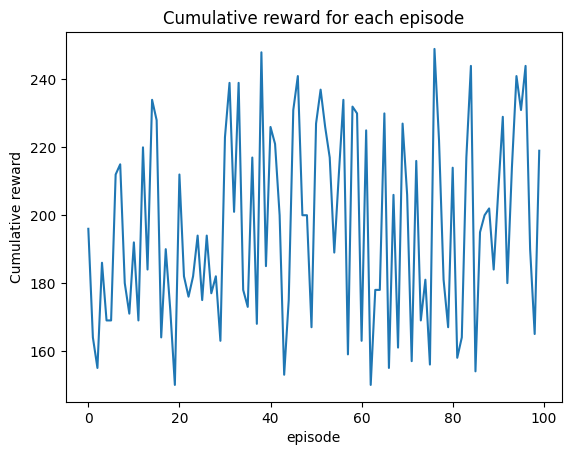

In [11]:
episode_results = np.random.randint(150, 250, size=100)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [12]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 196.34
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [13]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = rand_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
